<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
import random
seed = 56

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False


## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

for data in tqdm(dataset['train']):
    data_sentences = sent_tokenize(data['text'])
    for sentence in data_sentences:

        if len(word_tokenize(sentence)) < word_threshold:
            sentences.append(sentence)


  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


In [9]:
print(sentences[:10])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.', "Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.", 'While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema.', 'I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema.', "But really, this film doesn't have much of a plot.", '"I Am Curious: Yellow" is a risible and pretentious steaming pile.', "It doesn't matter what one's political views are because this film can hardly be taken seriously on any level.", "As for the claim that frontal male nudity is an automatic NC-17, that isn't true.", "I've seen R-rated films with male nudity.", 'Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia?']


Посчитаем для каждого слова его встречаемость.

In [10]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    tokens = word_tokenize(sentence)
    words.update(tokens)
    #print(tokens)

  0%|          | 0/198801 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
vocab.update([word for word, _ in words.most_common(vocab_size)])

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:

class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:

        sentence = self.data[idx]
        tokenized_sentence = word_tokenize(sentence)
        indexed_sentence = [word2ind.get(token, self.unk_id) for token in tokenized_sentence]
        tokenized_sentence = [self.bos_id] + indexed_sentence + [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)


In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state=seed)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5, random_state=seed)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size,
    generator=g, worker_init_fn=seed_worker)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size,
    generator=g, worker_init_fn=seed_worker)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size,
    generator=g, worker_init_fn=seed_worker)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [18]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5):
    torch.cuda.empty_cache()
    losses = []
    perplexities = []
    best_perplexity = float('inf')
    best_model = None

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()

            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)

        perplexity = evaluate(model, criterion, eval_dataloader)
        perplexities.append(perplexity)

        print(f'Epoch {epoch+1}; Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}')

        if perplexity < best_perplexity:
            best_perplexity = perplexity
            best_model = model.state_dict()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(perplexities, label='Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title('Perplexity over Epochs')
    plt.legend()
    plt.show()

    test_perplexity = evaluate(model, criterion, test_dataloader)
    print(f'Test perplexity: {test_perplexity:.5f}')
    return best_model, test_perplexity

### Эксперименты


####**В качестве бейзлайна используем модель с семинара CharLM**

**1 слой GRU**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.3913, Perplexity: 123.4930


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.7962, Perplexity: 90.9875


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.5763, Perplexity: 75.7672


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.4213, Perplexity: 66.8066


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.2985, Perplexity: 60.4128


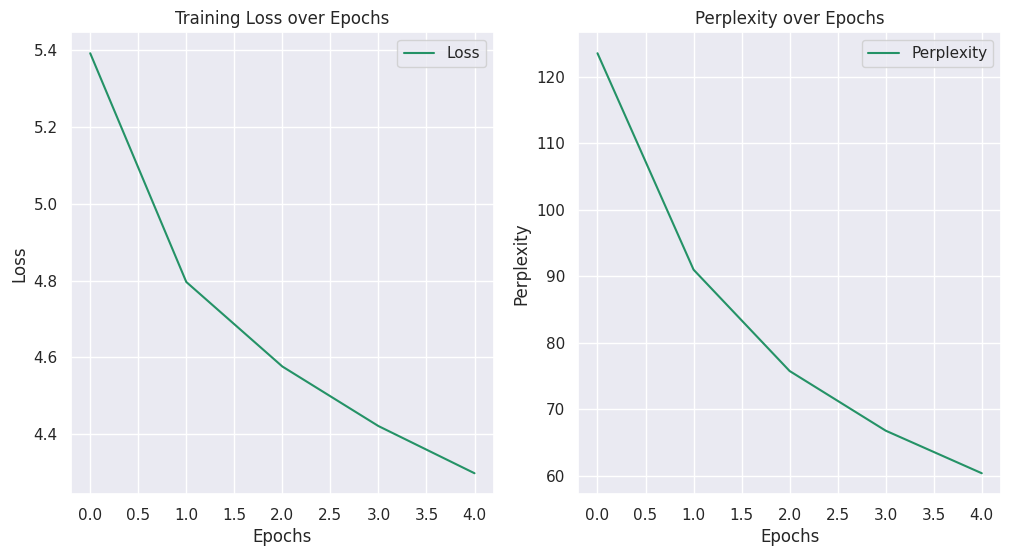

Test perplexity: 85.92198


In [ ]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# GRU 1 LAYER
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
base_best, base_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

####**Добавим второй слой GRU**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.6187, Perplexity: 144.8395


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.9232, Perplexity: 106.7143


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.7011, Perplexity: 89.7439


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.5456, Perplexity: 78.9070


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.4236, Perplexity: 72.0030


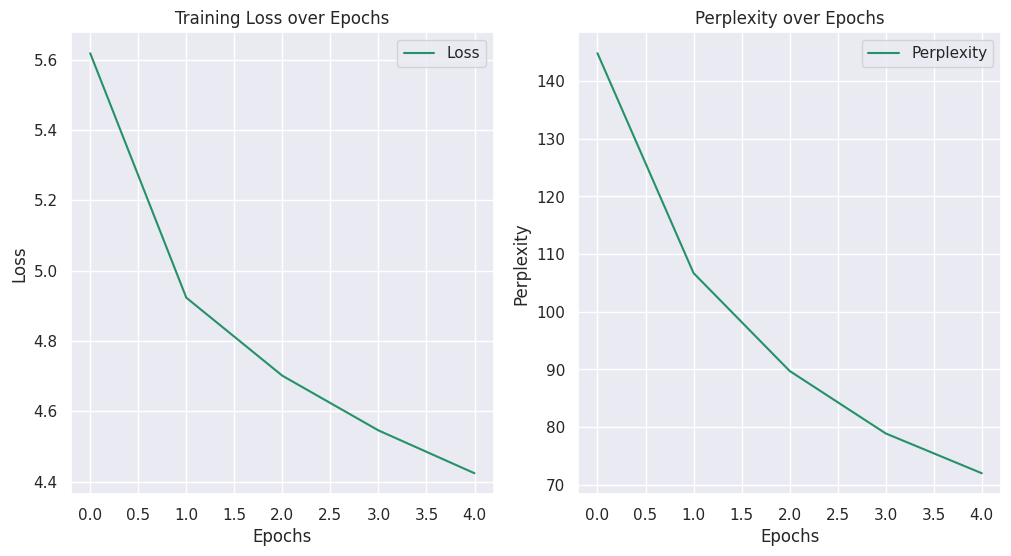

Test perplexity: 95.24086


In [ ]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2) ###
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# GRU 2 LAYERS
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm2_best, lm2_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)


Добавление второго слоя GRU не дало прироста к качеству, а наоборот уменьшило его.

Perplexity на тестовом наборе упало примерно на 10 единиц.

####**Попробуем LSTM вместо GRU**

1 слой LSTM

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.4651, Perplexity: 129.5948


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.8220, Perplexity: 93.8351


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.5926, Perplexity: 77.3064


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.4318, Perplexity: 67.2193


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.3039, Perplexity: 60.2578


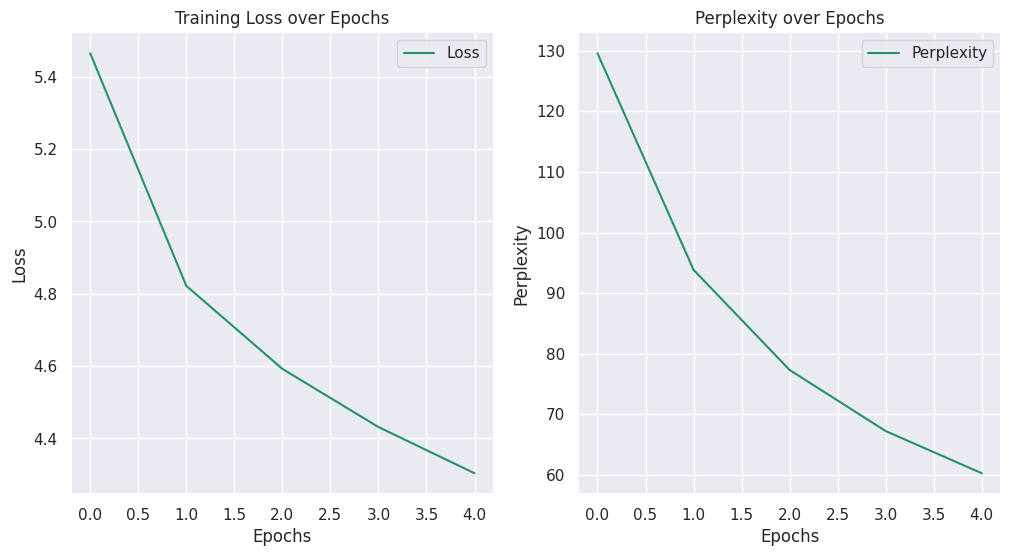

Test perplexity: 83.78491


In [ ]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# LSTM 1 LAYER
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm1_best, lm1_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

Однослойная LSTM показала себя немного лучше, чем однослойная GRU.

####**Возьмем двухслойную LSTM**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.7883, Perplexity: 166.1646


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 5.0111, Perplexity: 117.0266


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.7699, Perplexity: 97.3722


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.6104, Perplexity: 84.7376


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.4833, Perplexity: 76.6235


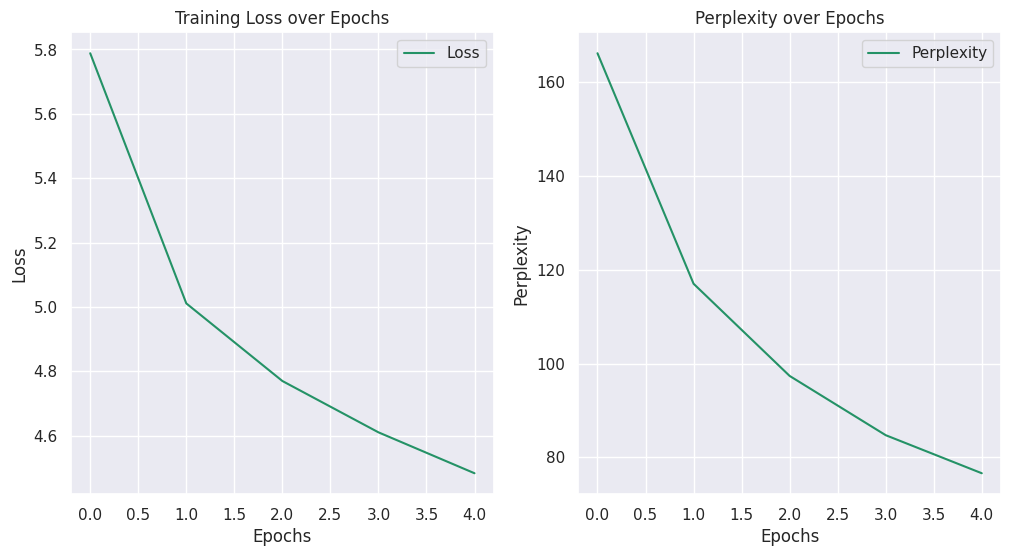

Test perplexity: 96.75698


In [ ]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# LSTM 2 LAYERS
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm3_best, lm3_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

Аналогично модели GRU, увеличение количества LSTM слоев не дает улучшений (по крайней мере в первые 5 эпох).

####**Остановимся на однослойной LSTM модели, увеличим размерность эмбеддингов до 384**

Размер hidden_dim оставим неизменным - 256.

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.3846, Perplexity: 119.0064


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.7605, Perplexity: 87.0022


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.5325, Perplexity: 71.7908


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.3696, Perplexity: 62.3446


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.2378, Perplexity: 55.6962


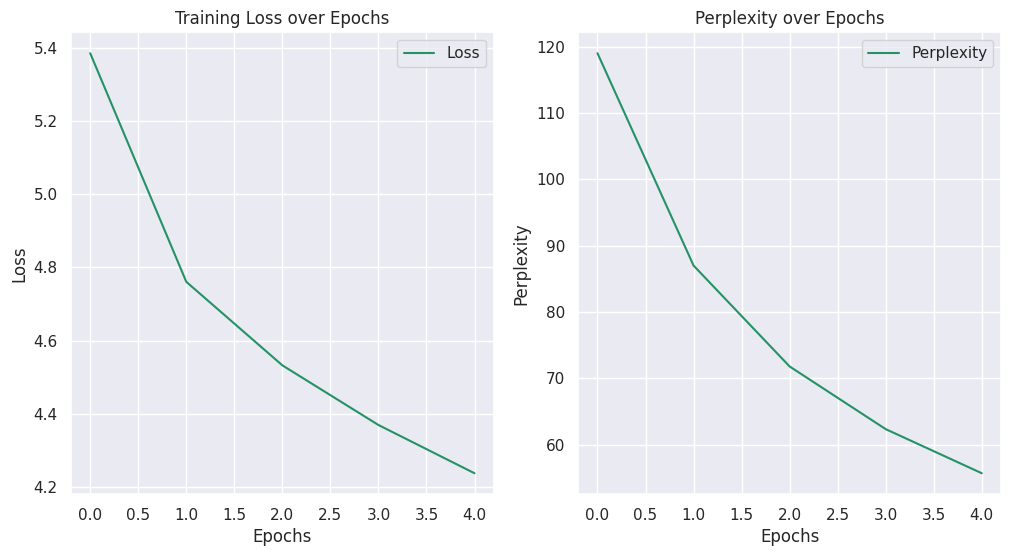

Test perplexity: 81.19391


In [ ]:
class CharLM(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# LSTM 1 LAYER, 384 EMBEDDING_DIM, 256 HIDDEN_DIM
model = CharLM(embedding_dim=384, hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm4_best, lm4_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

Увеличение размерности эмбеддингов в 1.5 раза улучшило качество модели с 83.78 до 81.19

####**Теперь попробуем увеличить размер hidden_dim до 384**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.2876, Perplexity: 105.5954


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.6572, Perplexity: 74.4856


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.3986, Perplexity: 59.7991


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.2036, Perplexity: 50.8916


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.0400, Perplexity: 44.4622


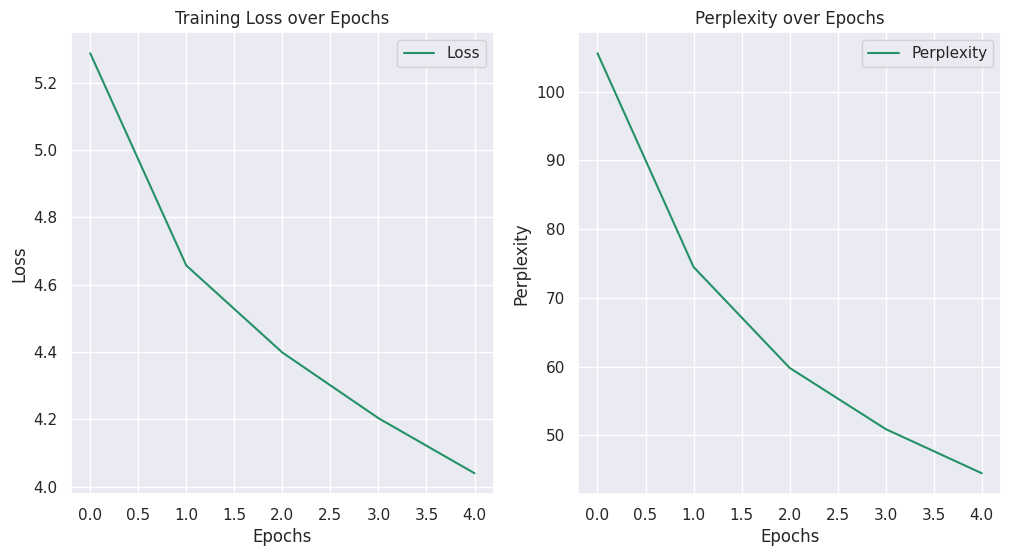

Test perplexity: 75.45872


In [ ]:
class CharLM(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# LSTM 1 LAYER, 384 EMBEDDING_DIM, 384 HIDDEN_DIM
model = CharLM(embedding_dim=384, hidden_dim=384, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm5_best, lm5_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

Модель стала показывать более высокое качество, чем в предыдущем эксперименте. С **81.19** до **75.45**

####**Вернемся к размерности 256. Попробуем увеличить количество линейных слоев**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.5181, Perplexity: 139.8666


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.9024, Perplexity: 103.8329


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.6889, Perplexity: 85.9430


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.5439, Perplexity: 75.4346


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.4317, Perplexity: 67.8692


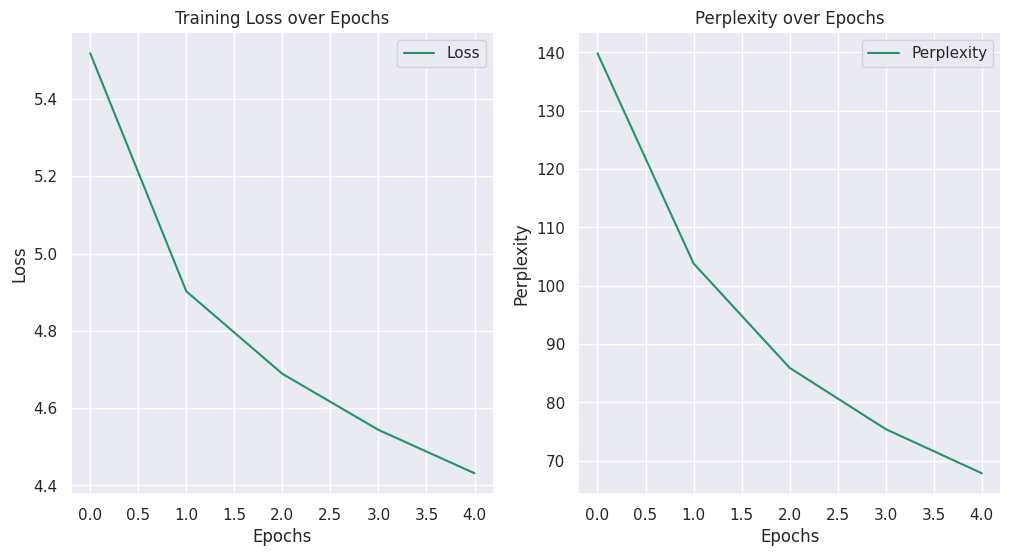

Test perplexity: 92.15505


In [ ]:
class CharLM(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

# LSTM 1 LAYER, 256 EMBEDDING_DIM, 256 HIDDEN_DIM, 2 LINEAR_LAYERS
model = CharLM(embedding_dim=256, hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm6_best, lm6_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

Качество модели упало до уровня немного лучше **двухслойной GRU**.

####**Улучшим предыдущую модель, увеличив размерности embedding_dim и hidden_dim до 384**

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 1; Loss: 5.3612, Perplexity: 115.0273


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 2; Loss: 4.7445, Perplexity: 81.7750


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 3; Loss: 4.5019, Perplexity: 66.3716


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 4; Loss: 4.3230, Perplexity: 56.7435


Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5; Loss: 4.1770, Perplexity: 50.2377


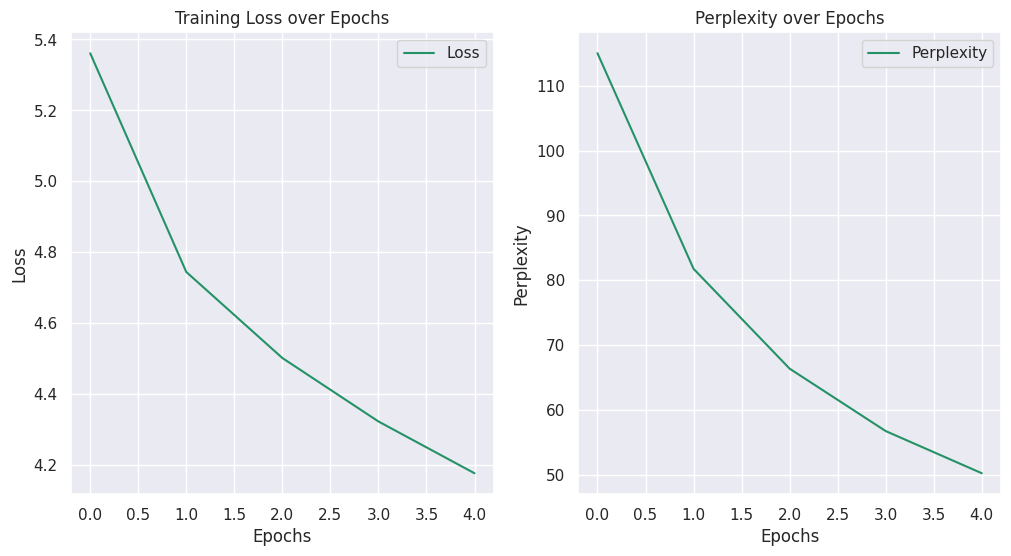

Test perplexity: 83.27751


In [ ]:
# LSTM 1 LAYER, 384 EMBEDDING_DIM, 384 HIDDEN_DIM, 2 LINEAR_LAYERS
model = CharLM(embedding_dim=384, hidden_dim=384, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
lm7_best, lm7_test_perplexity = train_model(model, train_dataloader, eval_dataloader, test_dataloader, optimizer, criterion, num_epoch=5)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

---

Были проведены эксперименты, демонстрирующие влияние типа RNN слоев, их количества, размерности эмбеддингов и слоев нейронной сети, а также количество линейных слоев.


**Влияние GRU и LSTM**

Модели с LSTM и с GRU не показали большой разницы на тестовых данных. LSTM показывает себя немного лучше.

**Влияние количества слоев GRU/LSTM**

Увеличение количества слоев GRU и LSTM для решения *данной задачи* не привело к успеху. Модели стали показывать себя хуже.

**Влияние размерности эмбеддингов и слоев модели**

После первых двух экспериментов была выбрана модель LSTM. Увеличение размерности эмбеддингов с 256 до 384 дало небольшой прирост к качеству (Perplexity улучшилось с 83.78 до 81.19).

Значительный прирост дало увеличение размерности и эмбеддингов, и скрытых слоев до 384. Perplexity улучшилось до 75.45.

**Увеличение количества линейных слоев**

Модель с размерностью эмбеддингов и слоев 256 и дополнительным линейным слоем не стала лучшем модели с 1 линейным слоем и размерностью 384.

Увеличение размерностей модели с доп. линейным слоем до 384 помогло значительно улучшить качество до 83.27.

   
---
   

На дальнейшие эксперименты, увы, закончилось гпу

